In [1]:
# import libaries
import math as math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
from tqdm import tqdm

Use the upwind scheme and Physics Informed Neural Network to approximate the solution of the hyperbolic equation

$\frac{\partial u}{\partial t}(x,t) + (x+1)\frac{\partial u}{\partial x}(x,t) = 0 \qquad (1)$                 

where $x \in [0,1]$ and $t \in [0,1]$. Equation (1) is supplemented by initial conditon

$u(x,0) = x +1, \quad \quad x \in [0,1]$

and the boundary conditon
$u(0,t) = \exp(-t), \quad \quad t \in [0,1]$

In [2]:
def Upwind(dx,h):
    
    assert dx>h and dx>0, f"The spatial step size {dx}  is invalid"
    
    t=np.arange(0,1+h,h)
    x=np.arange(0,1+dx,dx)
    U=np.zeros((len(t),len(x)))
    mu=lambda x: x+1
    IC=np.zeros(U.shape[1])
    
    for i in range(len(x)):
        IC[i]=1 + x[i]
    U[0,:]=IC

    BC=np.zeros(U.shape[0])

    for j in range(len(t)):
        BC[j]=np.exp(-t[j])
    U[:,0]=BC
   
    for n in range(len(t)-1):
        for i in range(1,len(x)):
            U[n+1,i]=U[n,i]+mu(x[i])*(h/dx)*U[n,i-1]-mu(x[i])*(h/dx)*U[n,i]
    
    
    # Exact soln
    E=np.zeros((len(t),len(x)))
    
    f1=lambda x,t:(x+1)*np.exp(-t)
    
    for i in range(len(t)):
        for j in range(len(x)):
            E[i,j]=f1(x[j],t[i])
    return U,E,x

In [3]:
class Advection(nn.Module):
    def __init__(self):
        super(Advection, self).__init__()

        self.features = nn.Sequential(
            nn.Linear(2,20), # we start with two inputs: x and t and expand to 20 neurons
            nn.Tanh(), # activation function
            
            nn.Linear(20,30), 
            nn.Tanh(), 
            
            nn.Linear(30,30), 
            nn.Tanh(), 
            
            nn.Linear(30,20), 
            nn.Tanh(), 
            
            nn.Linear(20,20), 
            nn.Tanh(), 

            # layer 6
            nn.Linear(20,1)
        )

    # define forward pass
    def forward(self,x):
        out = self.features(x)
        return out

In [4]:
class Net:
    def __init__(self):
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model = Advection().to(device)

        self.dx = 0.05
        self.dt = 0.01

        x = torch.arange(0,1+self.dx, self.dx)
        t = torch.arange(0,1+self.dt, self.dt)
        
        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        
        ## Apply BC and IC
        
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        
        ic = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        
        self.X_train = torch.cat([bc1,ic])

                # left BC
        y_bc1 = torch.exp(-1*bc1[:,1])

                # IC
        y_ic = torch.ones_like(ic[:,0]) + ic[:,0]
        
        self.y_train = torch.cat([y_bc1,y_ic])

        self.y_train = self.y_train.unsqueeze(1) # for shape consistency we have to unsqueeze

        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # Optimizer setting
        self.adam = torch.optim.Adam(self.model.parameters())

        # limited-memory Broyden-Fletche-Goldfarb-Shanno (L-BFGS)
        self.optimizer  = torch.optim.LBFGS(
            self.model.parameters(),
            lr = 0.1,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_grad=1e-7,
            tolerance_change=1.0* np.finfo(float).eps,
            line_search_fn='strong_wolfe'
        )

        self.criterion = torch.nn.MSELoss()
        self.iter =1

    
    def loss_func(self):

        # LOSS related to the data
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        # loss related to the data
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)

        # LOSS related to the PDE
        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u, self.X, 
            grad_outputs=torch.ones_like(u),
            create_graph = True,
            retain_graph = True)[0]

        #print(du_dx)
        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]


        loss_pde = self.criterion(du_dt, - (u.squeeze() + torch.ones_like(u.squeeze())) *du_dx)

        loss = loss_pde + loss_data

        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
            
        self.iter +=1

        return loss

    def train(self):
        self.model.train()

        # we use two optimizers
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [5]:
net =Net()
net.train()

/Users/stanleyakor/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391829313/work/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.030112333595752716
200 0.009886651299893856
300 0.0008910547476261854
400 0.0002737929462455213
500 0.0001953849714482203
600 0.00015351151523645967
700 0.0001285940525121987
800 0.00011379958596080542
900 0.00010476306488271803
1000 9.867401968222111e-05
1100 6.429395580198616e-05
1200 5.0809299864340574e-05
1300 2.9111444746376947e-05
1400 1.8469498172635213e-05
1500 1.4648727301391773e-05
1600 1.228359542437829e-05
1700 7.933329470688477e-06
1800 6.17835576122161e-06
1900 4.84323209093418e-06
2000 4.2586284507706296e-06
2100 3.421307155804243e-06
2200 2.7048797619499965e-06
2300 2.108123226207681e-06
2400 1.901122004710487e-06
2500 1.6313181276927935e-06
2600 1.2395753401506227e-06
2700 1.1363811154296855e-06
2800 8.84906569353916e-07


In [6]:
h=0.001;dx=0.05

x = torch.arange(0,1+dx,dx)
t = torch.arange(0,1+h,h)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

In [7]:

U,E,x=Upwind(dx,h)

In [8]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

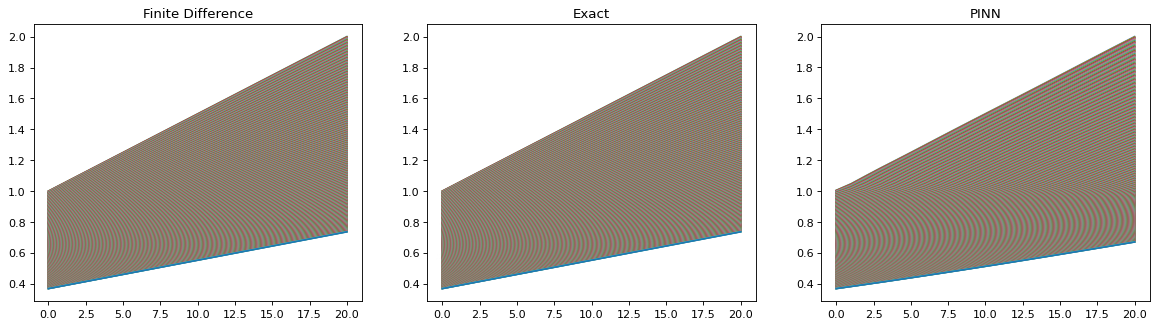

In [9]:
plt.figure(figsize=(18, 4.5), dpi=80)
for i in range(y_pred.shape[1]):
    plt.subplot(1, 3, 1)
    plt.plot(U[i,:])
    plt.title('Finite Difference')
    plt.subplot(1, 3, 2)
    plt.plot(E[i,:])
    plt.title('Exact')
    plt.subplot(1, 3, 3)
    plt.plot(y_pred[:,i])
    plt.title('PINN')

In [10]:
np.max(abs(E.T - y_pred))

0.2115274997505887

In [11]:
np.max(abs(E - U))

0.0003198746952211007

Although PINN approximated the solution reasonably well, its performance falls short compared to FD. Enhancing the performance of PINN can be achieved by employing a more advanced neural network architecture or conducting hyperparameter tuning.